In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from datetime import datetime
#from prophet import Prophet

pd.options.display.max_columns = None

In [46]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [47]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [48]:
def plot(self, model=None, plot_col='CONTEO', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [49]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [50]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Carga de datos

In [51]:
AccidentsDataset = pd.read_csv('/content/drive/MyDrive/Maestría/Datos/AccidentsConsolidatedDataset.csv',sep=',')
AccidentsDataset['FECHA']=AccidentsDataset['Unnamed: 0']
AccidentsDataset['FECHA'] = pd.to_datetime(AccidentsDataset['FECHA'])
AccidentsDataset.index = AccidentsDataset['FECHA']
AccidentsDataset=AccidentsDataset.drop(columns=['Unnamed: 0','FECHA','ANHO','MES','DIA','DIA_SEMANA'])

In [52]:
AccidentsDataset.head()

,CONTEO
FECHA,
2015-01-01,13
2015-01-02,68
2015-01-03,69
2015-01-04,78
2015-01-05,57


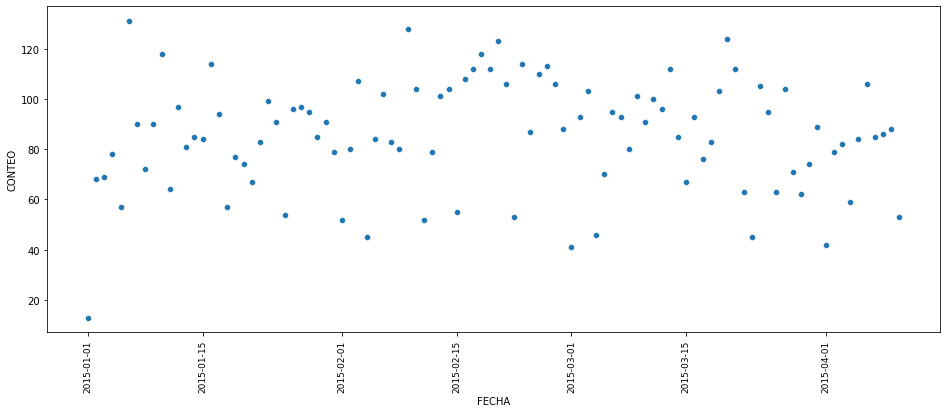

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=AccidentsDataset[0:100].index,y=AccidentsDataset[0:100].CONTEO)


No handles with labels found to put in legend.


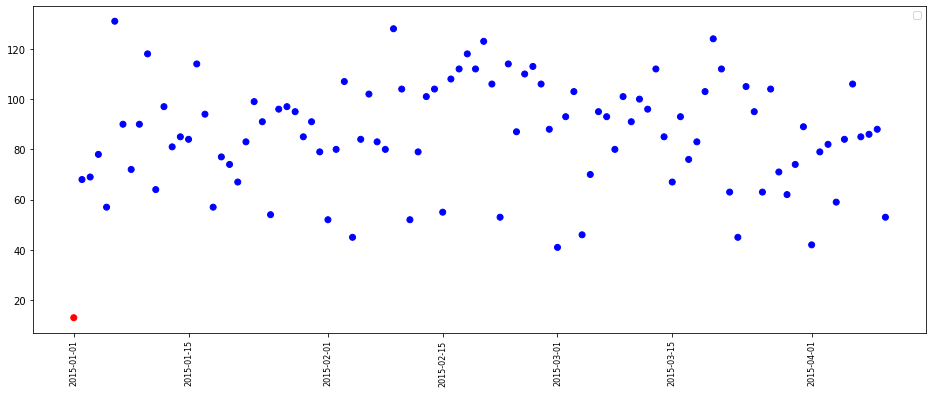

In [54]:
import matplotlib as pl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
series = AccidentsDataset
outliers_fraction = 0.01
data = series[['CONTEO']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
dataScaled = pd.DataFrame(data)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(dataScaled)
anomalyResults = pd.Series(model.predict(dataScaled))
# visualization
fig, ax = pl.pyplot.subplots(figsize=(16,6))
series['anomaly2']=np.zeros(len(series))
plt.xticks(rotation=90, fontsize=8)
for i in range (0,len(anomalyResults)):
  series.loc[series.index[i],'anomaly2']= anomalyResults[i]
colors = {1:'blue', -1:'red'}
ax.scatter(series[:100].index, series[:100]['CONTEO'], c=series[:100]["anomaly2"].apply(lambda x: colors[x]))

pl.pyplot.legend()
pl.pyplot.show();
DataUsingIsolationForest = series.copy()

No handles with labels found to put in legend.


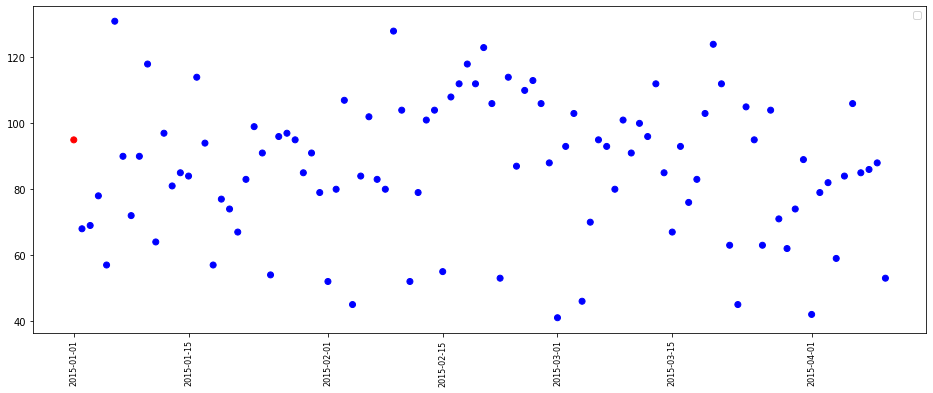

In [55]:
for i in AccidentsDataset.index:
  if AccidentsDataset.loc[i,'anomaly2']==-1:
    AccidentsDataset.loc[i,'CONTEO']= AccidentsDataset['CONTEO'].mean()
fig, ax = pl.pyplot.subplots(figsize=(16,6))
plt.xticks(rotation=90, fontsize=8)
colors = {1:'blue', -1:'red'}
ax.scatter(AccidentsDataset[:100].index, AccidentsDataset[:100]['CONTEO'], c=AccidentsDataset[:100]["anomaly2"].apply(lambda x: colors[x]))

pl.pyplot.legend()
pl.pyplot.show();

In [63]:
AccidentsDataset = AccidentsDataset.drop(columns=['anomaly2'])
n = len(AccidentsDataset)
num_features = AccidentsDataset.shape[1]
train_df = AccidentsDataset[0:int(n*0.7)]
val_df = AccidentsDataset[int(n*0.7):int(n*0.9)]
test_df = AccidentsDataset[int(n*0.9):]
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


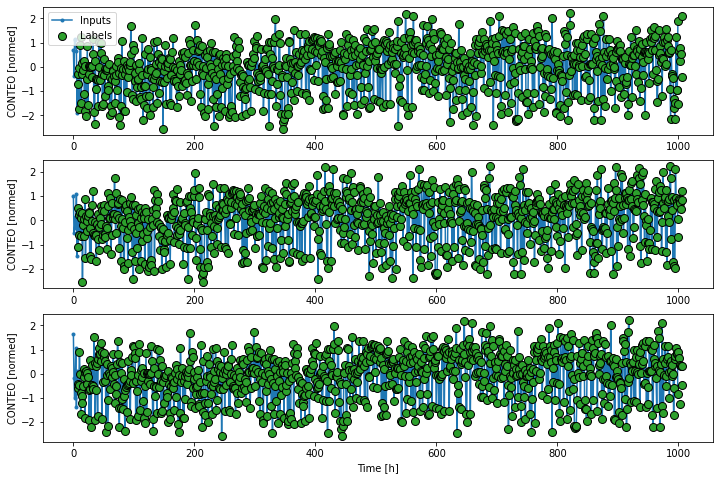

In [57]:
#MODELO DE VENTANA AMPLIA
val_performance = {}
performance = {}
INPUT_STEPS =1000
OUT_STEPS =1000
SHIFT =7 # 1 semana
wide_window = WindowGenerator(train_df=train_df,test_df=test_df,val_df=val_df,
    input_width=INPUT_STEPS, label_width=OUT_STEPS, shift=SHIFT,
    label_columns=['CONTEO'])

wide_window.plot()

In [58]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, use_multiprocessing=True)
  return history

Epoch 1/500
9/9 [==============================] - 28s 957ms/step - loss: 0.9778 - mean_absolute_error: 0.7983
Epoch 2/500
9/9 [==============================] - 9s 965ms/step - loss: 0.9621 - mean_absolute_error: 0.7894
Epoch 3/500
9/9 [==============================] - 9s 968ms/step - loss: 0.9461 - mean_absolute_error: 0.7807
Epoch 4/500
9/9 [==============================] - 9s 960ms/step - loss: 0.9409 - mean_absolute_error: 0.7785
Epoch 5/500
9/9 [==============================] - 9s 950ms/step - loss: 0.9399 - mean_absolute_error: 0.7783
Epoch 6/500
9/9 [==============================] - 9s 946ms/step - loss: 0.9398 - mean_absolute_error: 0.7785
Epoch 7/500
9/9 [==============================] - 9s 947ms/step - loss: 0.9397 - mean_absolute_error: 0.7786
Epoch 8/500
9/9 [==============================] - 9s 944ms/step - loss: 0.9394 - mean_absolute_error: 0.7785
Epoch 9/500
9/9 [==============================] - 9s 947ms/step - loss: 0.9394 - mean_absolute_error: 0.7786
Epoch 10/

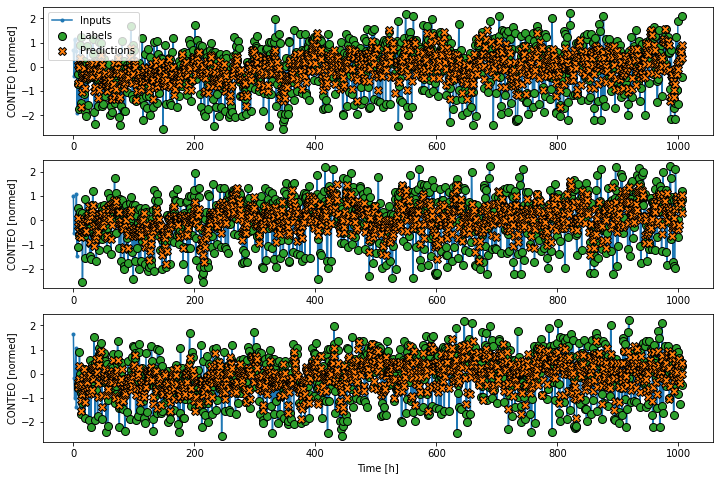

In [59]:
import tensorflow_datasets as tfds

def buildModel(retrain,route):
  if retrain:
    multi_lstm_model = tf.keras.Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(OUT_STEPS*num_features),
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    history = compile_and_fit(multi_lstm_model, wide_window)
    multi_lstm_model.save(route)
    return multi_lstm_model
  else:
    multi_lstm_model = tf.keras.models.load_model(route)
    return multi_lstm_model

ROUTE = '/content/drive/MyDrive/Maestría/LstmAccidents.h5'
RETRAIN =True
multi_lstm_model = buildModel(RETRAIN,ROUTE)
wide_window.plot(multi_lstm_model)
print(multi_lstm_model.summary())

In [60]:
AccidentsDataset[-10:]

,CONTEO,anomaly2
FECHA,,
2019-12-22,80.0,1.0
2019-12-23,109.0,1.0
2019-12-24,88.0,1.0
2019-12-25,50.0,1.0
2019-12-26,100.0,1.0
2019-12-27,83.0,1.0
2019-12-28,63.0,1.0
2019-12-29,50.0,1.0
2019-12-30,79.0,1.0


In [61]:
SeriesToPredict = AccidentsDataset[-1001:]

ds_pred = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=SeriesToPredict,
      targets=None,
      sequence_length=OUT_STEPS,
      sequence_stride=OUT_STEPS,
      shuffle=False,
      batch_size=1,)
print(ds_pred)
prediction = multi_lstm_model.predict(ds_pred)

<BatchDataset shapes: (None, None, 2), types: tf.float64>


In [89]:
predictions_result=prediction[0][-7:]
predictions_list =[]
print(train_mean['CONTEO'])
for result in predictions_result:
  predictions_list.append((int)(result[1]*train_std['CONTEO'])+train_mean['CONTEO'])
print(len(predictions_list))
print(np.arange(0,7))

94.18509592140883
7
[0 1 2 3 4 5 6]


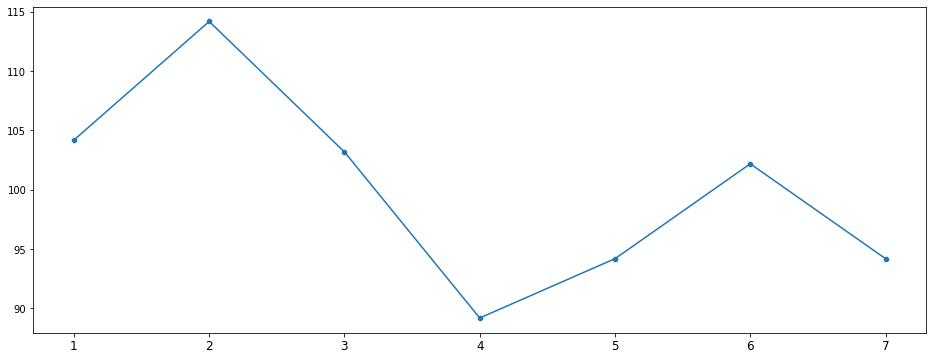

In [94]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=0, fontsize=12)
sns.scatterplot(x=np.arange(1,8),y=predictions_list)
sns.lineplot(x=np.arange(1,8),y=predictions_list)